### Machine learning detection of pesticides from Raman spectroscopy by using CNN, XGBoost, SVM, and their hybrid integration.

#### Getting started

- Extract and classify Raman spectra images from Word file (.docx) into training set for CNN model

In [14]:
import os
from docx import Document
from PIL import Image
from io import BytesIO
import hashlib
from utils.utils_data import get_all_images_sorted

# Mapping file name → class label
docx_files = {
    "carbendazim.docx": "CBZ",
    "carbaryl.docx": "CR",
    "thiram.docx": "TMTD",
    "thiabendazole.docx": "TBZ",
    "rhodamine_6G.docx": "R6G",
    "rhodamine_B.docx": "RB",
    "crystal_violet.docx": "CV",
    "methyl_parathion.docx": "MP",
    "cypermethrin.docx": "CYP",
    "chlorpyrifos.docx": "CPF"
}

input_folder  = r"./data/"
output_folder = r"./data/train/"
os.makedirs(output_folder, exist_ok=True)

image_hashes = set()
class_counts = {}

for docx_filename, label in docx_files.items():
    file_path = os.path.join(input_folder, docx_filename)
    if not os.path.exists(file_path):
        print(f"Not found: {file_path}")
        continue

    doc = Document(file_path)
    label_dir = os.path.join(output_folder, label)
    os.makedirs(label_dir, exist_ok=True)

    count = 0

    # ==== get images reproducible ====
    images = get_all_images_sorted(doc)

    for image_data in images:
        image_hash = hashlib.md5(image_data).hexdigest()
        if image_hash not in image_hashes:
            image = Image.open(BytesIO(image_data))

            if image.width >= 100 and image.height >= 100:
                image.save(os.path.join(label_dir, f"{label}_{count}.png"))
                image_hashes.add(image_hash)
                count += 1

    class_counts[label] = count

# Print overall summary
print("\n📊 Total images extracted:")
for label, count in class_counts.items():
    print(f"{label}: {count} images")
print("Total:", sum(class_counts.values()))
print("✅ Extraction Raman dataset complete!")


📊 Total images extracted:
CBZ: 135 images
CR: 128 images
TMTD: 229 images
TBZ: 239 images
R6G: 101 images
RB: 100 images
CV: 111 images
MP: 104 images
CYP: 100 images
CPF: 100 images
Total: 1347
✅ Extraction Raman dataset complete!


### Dataset
- 80% training, 20% validation (ensure no original images are lost)

In [15]:
from glob import glob
import os, random
import shutil

DATA_ROOT = "./data/train/"
OUTPUT_ROOT = "./data/"
OUT_TRAIN = os.path.join(OUTPUT_ROOT, "train_clean")
OUT_VAL   = os.path.join(OUTPUT_ROOT, "val_clean")

train_ratio = 0.8
SEED = 42

# ===== CLEAN OUTPUT DIRS =====
for d in [OUT_TRAIN, OUT_VAL]:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d)

# =====  CLASS NAMES =====
classes = sorted(os.listdir(DATA_ROOT))
print("Classes:", classes)

for cls in classes:
    src_cls = os.path.join(DATA_ROOT, cls)
    imgs = sorted(glob(os.path.join(src_cls, "*.*")))

    rng = random.Random(SEED)
    rng.shuffle(imgs)

    n_total = len(imgs)
    n_train = int(n_total * train_ratio)

    train_files = imgs[:n_train]
    val_files   = imgs[n_train:]

    train_dst = os.path.join(OUT_TRAIN, cls)
    val_dst   = os.path.join(OUT_VAL, cls)
    os.makedirs(train_dst, exist_ok=True)
    os.makedirs(val_dst, exist_ok=True)

    # ===== HARDLINK =====
    for f in train_files:
        os.link(f, os.path.join(train_dst, os.path.basename(f))) 
    for f in val_files:
        os.link(f, os.path.join(val_dst, os.path.basename(f)))

    # print(f"{cls}: Total={n_total}: Train={len(train_files)}, Val={len(val_files)}")

print(f"\n SPLIT_TRAIN = {train_ratio}", f" (Seed={SEED})")
print(f"➡️  New directories: {OUT_TRAIN}  and  {OUT_VAL}")

Classes: ['CBZ', 'CPF', 'CR', 'CV', 'CYP', 'MP', 'R6G', 'RB', 'TBZ', 'TMTD']

 SPLIT_TRAIN = 0.8  (Seed=42)
➡️  New directories: ./data/train_clean  and  ./data/val_clean


- Checking dataset

Class    Train  Val    Total  Train Ratio (%)
--------------------------------------------------
CBZ      108    27     135     80.00
CPF      80     20     100     80.00
CR       102    26     128     79.69
CV       88     23     111     79.28
CYP      80     20     100     80.00
MP       83     21     104     79.81
R6G      80     21     101     79.21
RB       80     20     100     80.00
TBZ      191    48     239     79.92
TMTD     183    46     229     79.91


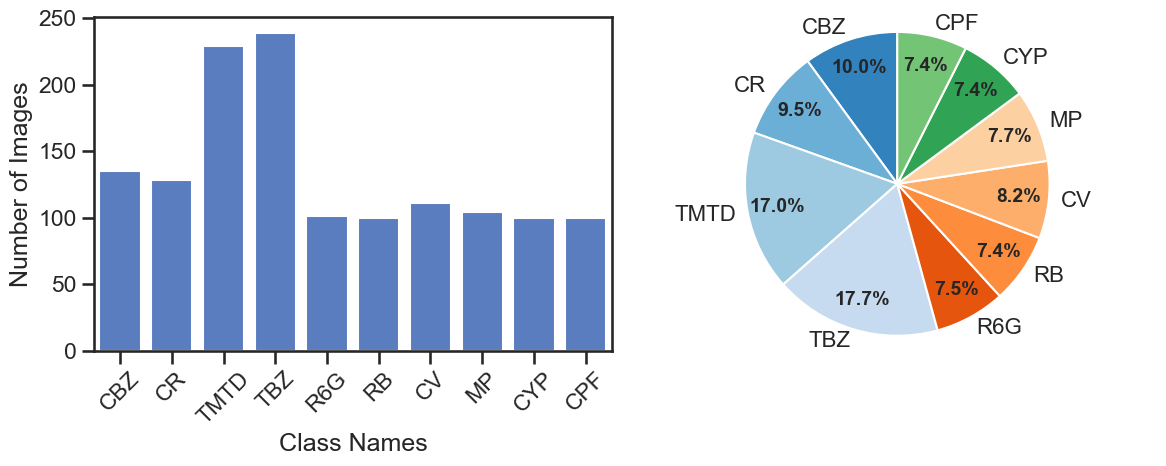

✅ Saved Class Distribution -> ./output/class_distribution.pdf


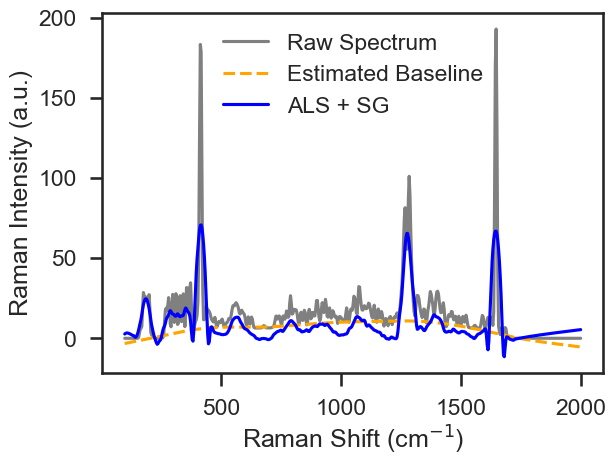

✅ Saved Class Distribution -> ./output/preprocessing_comparison_sample.pdf


In [1]:
import os
from utils.utils_plot import plot_dataset_distribution
from utils.utils_data import process_and_plot_spectrums

# Train and val directories
train_dir = r"./data/train_clean"
val_dir   = r"./data/val_clean"
out_dir   = r"./output"

classes = sorted(os.listdir(train_dir))
print(f"{'Class':<8} {'Train':<6} {'Val':<6} {'Total':<6} {'Train Ratio (%)'}")
print("-" * 50)

for cls in classes:
    train_count = len(os.listdir(os.path.join(train_dir, cls)))
    val_count   = len(os.listdir(os.path.join(val_dir, cls)))
    total       = train_count + val_count
    ratio       = train_count / total * 100 if total > 0 else 0
    print(f"{cls:<8} {train_count:<6} {val_count:<6} {total:<6} {ratio:>6.2f}")

# Plot dataset distribution
plot_dataset_distribution()

# Compare the Raman data processing
image_path = r"./data/train/TMTD/TMTD_56.png"
process_and_plot_spectrums(image_path)


### Training model ResNet18 with PyTorch

- Load the Raman spectral image data with train/val split.
- Preprocess the image.
- Train the ResNet18 model.
- Apply early stopping technique to avoid overfitting.
- Save the model.

In [2]:
import os, time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Check device
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======= DIRECTORIES =======
train_dir  = r"./data/train_clean"
val_dir    = r"./data/val_clean"
model_dir = r"./model/"
out_dir   = r"./output/"

os.makedirs(model_dir, exist_ok=True)
stamp = time.strftime("%Y%m%d")

# ======= Hyperparameters =======
batch_size = 32
img_size   = 256   # options: 224, 256, 288, 320, 384
epochs     = 25
patience   = 6     # epochs to wait for early stopping
min_delta  = 0.01  # value to consider as convergence of val_loss

# ================= AUGMENTATION ================
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.8)),   
    transforms.ColorJitter(brightness=0.05, contrast=0.05),   # change brightness and contrast
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
val_data   = datasets.ImageFolder(val_dir, transform=val_transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=batch_size, shuffle=False)

num_classes = len(train_data.classes)

# ================= MODEL =================
weights = models.ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)

model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.fc.in_features, num_classes)
)
model.to(device)

# ================= TRAIN SETUP =================
criterion = nn.CrossEntropyLoss(label_smoothing=0.02)
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=5e-5)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=8, T_mult=2, eta_min=1e-6
)

train_accs, val_accs = [], []
train_losses, val_losses = [], []
best_val_loss = float("inf")
early_stop = 0

# ================= TRAIN LOOP =================
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct, total = 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # ===== VAL =====
    model.eval()
    val_loss_sum = 0
    correct, total = 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss_sum += loss.item() * imgs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss_sum / total
    val_acc  = correct / total

    scheduler.step(epoch)

    print(f"Epoch {epoch+1:02d}/{epochs} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    train_accs.append(train_acc); val_accs.append(val_acc)
    train_losses.append(train_loss); val_losses.append(val_loss)

    # # EARLY STOPPING
    # if val_loss < best_val_loss - min_delta:
    #     best_val_loss = val_loss
    #     torch.save(model.state_dict(), os.path.join(model_dir, f"GNN_model_{stamp}.pth"))
    #     early_stop = 0
    # else:
    #     early_stop += 1
    #     if early_stop >= patience:
    #         print("EARLY STOPPING"); break

    torch.save(model.state_dict(), os.path.join(model_dir, f"GNN_model_{stamp}.pth"))

print("✅ Training complete!")

Epoch 01/25 | Train Acc: 0.4670 | Val Acc: 0.5037 | Train Loss: 1.5609 | Val Loss: 1.6331
Epoch 02/25 | Train Acc: 0.7656 | Val Acc: 0.6140 | Train Loss: 0.7488 | Val Loss: 1.1986
Epoch 03/25 | Train Acc: 0.9088 | Val Acc: 0.6140 | Train Loss: 0.4215 | Val Loss: 1.4268
Epoch 04/25 | Train Acc: 0.9712 | Val Acc: 0.7206 | Train Loss: 0.2521 | Val Loss: 0.9539
Epoch 05/25 | Train Acc: 0.9944 | Val Acc: 0.7537 | Train Loss: 0.1930 | Val Loss: 0.9002
Epoch 06/25 | Train Acc: 0.9981 | Val Acc: 0.7757 | Train Loss: 0.1725 | Val Loss: 0.7928
Epoch 07/25 | Train Acc: 1.0000 | Val Acc: 0.7794 | Train Loss: 0.1627 | Val Loss: 0.7824
Epoch 08/25 | Train Acc: 1.0000 | Val Acc: 0.7831 | Train Loss: 0.1585 | Val Loss: 0.7770
Epoch 09/25 | Train Acc: 1.0000 | Val Acc: 0.7794 | Train Loss: 0.1558 | Val Loss: 0.7644
Epoch 10/25 | Train Acc: 1.0000 | Val Acc: 0.7721 | Train Loss: 0.1546 | Val Loss: 0.8121
Epoch 11/25 | Train Acc: 1.0000 | Val Acc: 0.7904 | Train Loss: 0.1565 | Val Loss: 0.8161
Epoch 12/2

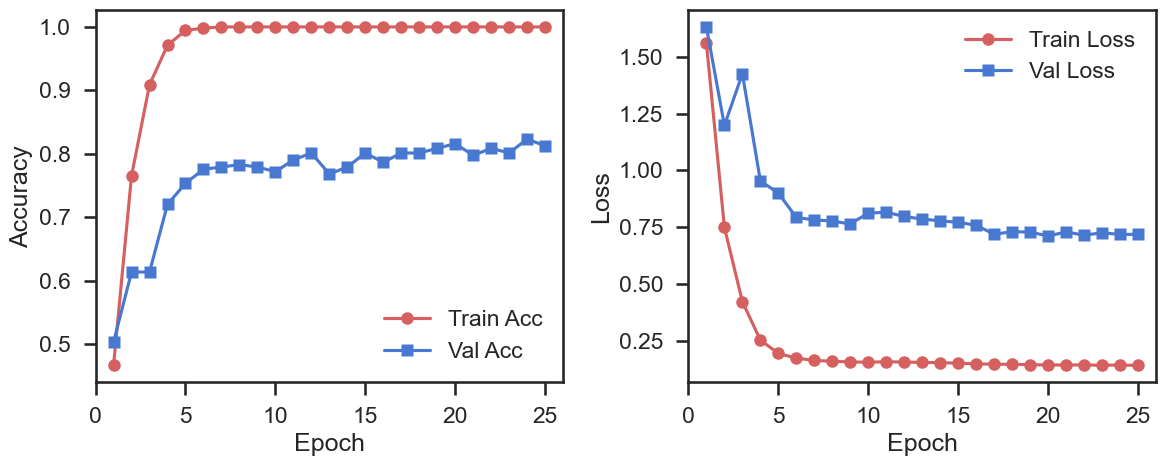

✅ Plot saved to: ./output/training_curves_plot.pdf


In [3]:
from utils.utils_plot import plot_training_curves

plot_training_curves(
    train_accs, val_accs,
    train_losses, val_losses,
    output_dir = out_dir,
    filename_prefix = "training_curves"
)

In [19]:
import time, json, os, torch

# Output folder
model_dir = r"./model/"
train_dir  = r"./data/train_clean"

stamp = time.strftime("%Y%m%d")
GNN_path = os.path.join(model_dir, f"GNN_model_{stamp}.pth")
ver_path  = os.path.join(model_dir, f"resnet18_10cls_{stamp}.pth")

# Load class names from training data
class_names = sorted(os.listdir(train_dir))
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
print("Class names:", class_names)

checkpoint = {
    "arch": "resnet18",
    "state_dict": torch.load(GNN_path, map_location="cpu", weights_only=True),
    "classes": class_names,
    "class_to_idx": class_to_idx,
    "img_size": 256,
    "normalize": {"mean": [0.485, 0.456, 0.406], "std": [0.229, 0.224, 0.225]},
}

torch.save(checkpoint, ver_path)
print("✅ Saved:", ver_path)

with open(os.path.join(model_dir, f"model_meta_{stamp}.json"), "w", encoding="utf-8") as f:
    json.dump({k: v for k, v in checkpoint.items() if k != "state_dict"}, f, ensure_ascii=False, indent=2)

Class names: ['CBZ', 'CPF', 'CR', 'CV', 'CYP', 'MP', 'R6G', 'RB', 'TBZ', 'TMTD']
✅ Saved: ./model/resnet18_10cls_20251115.pth


#### Extract features from the trained CNN model (ResNet18) and save it to .npy format

- Reload the best trained CNN model (best_model.pth).
- Remove the last fully connected layer, keeping only the "feature extractor" part.
- Extract the output features (feature vector) from the dataset (train + val).
- Save the features (X_cnn) and labels (y_cnn) to .npy files for use in other ML algorithms such as SVM, KNN, XGBoost,...

In [20]:
# === EXTRACT 512-D FEATURES FROM RESNET18 (ONE-CELL VERSION) ===
import os, json
import numpy as np
import torch
import torch.nn as nn
from utils.utils_model import load_checkpoint, build_model, build_loader

# ---------- CONFIG (set your paths with names of saved resnet18 above cells) -------
ckpt_path = r"./model/resnet18_10cls_20251115.pth"
train_dir = r"./data/train_clean"
val_dir   = r"./data/val_clean"
out_dir   = r"./output"

batch_size = 32
override_img_size = None     # e.g. 256/288 or None to use checkpoint
override_mean_std = None     # e.g. ([0.485,0.456,0.406],[0.229,0.224,0.225]) or None

# ---------------------------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs(out_dir, exist_ok=True)

# 1) Load ckpt + meta
state_dict, classes_meta, img_size, mean, std = load_checkpoint(ckpt_path)
if override_img_size is not None:
    img_size = int(override_img_size)
if override_mean_std is not None:
    mean, std = override_mean_std

# 2) Rebuild model + feature extractor
num_classes = len(classes_meta) if classes_meta is not None else None
model = build_model(state_dict, num_classes=num_classes).to(device)
feature_extractor = nn.Sequential(*list(model.children())[:-1]).to(device)  # ignore FC, keep avgpool

# 3) Loader eval (no augment)
loader, classes_ds, filenames = build_loader(
    train_dir, val_dir, img_size, mean, std, batch_size, device
)
classes = classes_meta if classes_meta is not None else classes_ds

# 4) Extract features
features_list, labels_list = [], []
with torch.inference_mode():
    for x, y in loader:
        x = x.to(device)
        h = feature_extractor(x)            # (B, 512, 1, 1)
        h = h.view(h.size(0), -1).cpu().numpy()  # (B, 512)
        features_list.append(h)
        labels_list.append(y.numpy())

X = np.concatenate(features_list, axis=0)   # (N, 512)
y = np.concatenate(labels_list, axis=0)     # (N,)

# 5) Save outputs
np.save(os.path.join(out_dir, "features_cnn.npy"), X)
np.save(os.path.join(out_dir, "labels_cnn.npy"),   y)
with open(os.path.join(out_dir, "filenames_cnn.json"), "w", encoding="utf-8") as f:
    json.dump(filenames, f, ensure_ascii=False, indent=2)
with open(os.path.join(out_dir, "classes.json"), "w", encoding="utf-8") as f:
    json.dump(classes, f, ensure_ascii=False, indent=2)
with open(os.path.join(out_dir, "features_meta.json"), "w", encoding="utf-8") as f:
    json.dump({
        "ckpt_path": ckpt_path,
        "img_size": img_size,
        "normalize": {"mean": mean, "std": std},
        "num_features": int(X.shape[1]),
        "num_samples": int(X.shape[0]),
        "device_used": device,
    }, f, ensure_ascii=False, indent=2)

print("✅ Done.")
print("  features_cnn.npy  :", X.shape)
print("  labels_cnn.npy    :", y.shape)
print("  filenames_cnn.json:", len(filenames))
print("  classes.json      :", len(classes))

✅ Done.
  features_cnn.npy  : (1347, 512)
  labels_cnn.npy    : (1347,)
  filenames_cnn.json: 1347
  classes.json      : 10


#### Train the XGBoost model on the features extracted from CNN and evaluate with Classification Report & Confusion Matrix

Use the features extracted from CNN (ResNet18) to train an XGBoost model to classify 4
substances (CBR, carbaryl, thiabendazole, thiram).

Evaluate the model performance with:
- Classification report: precision, recall, f1-score by class.
- Confusion matrix: display confusion between classes.
- Class-wise chart: visual comparison of metrics by class.



In [21]:
# =================== XGBoost with features from CNN ===================
import os, json, warnings
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")

# ======= PATHS =======
out_dir = r"./output/"
os.makedirs(out_dir, exist_ok=True)

# ======= LOAD FEATURES/LABELS =======
X = np.load(os.path.join(out_dir, "features_cnn.npy"))
y = np.load(os.path.join(out_dir, "labels_cnn.npy"))

# ======= LOAD CLASS NAMES =======
classes_path = os.path.join(out_dir, "classes.json")
if os.path.exists(classes_path):
    import json
    with open(classes_path, "r", encoding="utf-8") as f:
        class_names = json.load(f)
else:
    class_names = ['CBZ', 'CPF', 'CR', 'CV', 'CYP', 'MP', 'R6G', 'RB', 'TBZ', 'TMTD']

num_classes = len(class_names)
assert y.max() < num_classes, "❌ Label in y exceeds number of classes!"

# ======= SPLIT DATA =======
X_train, X_test, y_train, y_test = train_test_split(
    X.astype(np.float32, copy=False), y, test_size=0.15, stratify=y, random_state=42
)

# ======= TRAIN XGBOOST WITH PCA =======
model = Pipeline([
    ('pca', PCA(n_components=128, random_state=42)),
    ('xgb', XGBClassifier(
        n_estimators=400, max_depth=6, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.85,
        objective="multi:softprob", num_class=num_classes,
        eval_metric="mlogloss", tree_method="hist",
        random_state=42, n_jobs=-1
    ))
])

model.fit(X_train, y_train)

# ======= PREDICT =======
y_pred  = model.predict(X_test)
y_score = model.predict_proba(X_test)  # used for ROC
acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro")

# ==== Save folder ====
out_dir = r"./output/"
os.makedirs(out_dir, exist_ok=True)

# ==== Save model ====
json_path = os.path.join(out_dir, "xgb_on_cnn.json")   # XGBoost
pkl_path  = os.path.join(out_dir, "xgb_on_cnn.pkl")    # joblib (optional)

#model.save_model(json_path)        # save in XGBoost JSON format
joblib.dump(model, pkl_path)       # optional 

print("✅ Saved:")
# print(" -", json_path)
print(" -", pkl_path)
# print(" -", os.path.join(out_dir, "xgb_meta.json"))

✅ Saved:
 - ./output/xgb_on_cnn.pkl


In [22]:
# ==== ROC + Confusion + F1-bar for saved XGBoost, test = val_clean ====
import os, json, pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    roc_curve, auc, roc_auc_score, classification_report
)
import xgboost as xgb

# ---------- PATHS ----------
out_dir   = r"./output/"
train_dir = r"./data/train_clean"
val_dir   = r"./data/val_clean"
feat_path = os.path.join(out_dir, "features_cnn.npy")
lab_path  = os.path.join(out_dir, "labels_cnn.npy")
cls_path  = os.path.join(out_dir, "classes.json")
#xgb_json  = os.path.join(out_dir, "xgb_on_cnn.json")
xgb_pkl   = os.path.join(out_dir, "xgb_on_cnn.pkl")

# ---------- LOAD FEATURES & LABELS ----------
X = np.load(feat_path)  # (N, D) = train before, val after
y = np.load(lab_path)   # (N,)

# ---------- Class ----------
with open(cls_path, "r", encoding="utf-8") as f:
    class_names = json.load(f)
n_classes = len(class_names)
assert y.max() < n_classes, "Label in y exceeds number of classes!"

# ---------- COUNT IMAGES ----------
def count_images(root):
    exts = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}
    c = 0
    for d, _, files in os.walk(root):
        c += sum(1 for f in files if os.path.splitext(f.lower())[1] in exts)
    return c

n_train = count_images(train_dir)
assert 0 < n_train < len(X), "Invalid number of training images!"

X_train, y_train = X[:n_train],  y[:n_train]
X_test,  y_test  = X[n_train:],  y[n_train:]
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

# ---------- LOAD SAVED MODEL ----------
def load_xgb(pkl_path):
    if os.path.exists(pkl_path):
        import joblib
        return joblib.load(pkl_path)
    else:
        raise FileNotFoundError("Cannot find xgb_on_cnn.pkl")

model = load_xgb(xgb_pkl)

# ---------- PREDICTION (VAL_CLEAN) ----------
proba  = model.predict_proba(X_test)        # shape: (N_val, C)
y_pred = proba.argmax(1)

print("\n📋 Classification Report (test = val_clean):")
print(classification_report(y_test, y_pred, target_names=class_names, digits=3))

# ---------- ROC/AUC: per-class + micro/macro ----------
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

auc_micro = roc_auc_score(y_test_bin, proba, average="micro", multi_class="ovr")
auc_macro = roc_auc_score(y_test_bin, proba, average="macro", multi_class="ovr")
print(f"\nAUC (sklearn): micro = {auc_micro:.3f} | macro = {auc_macro:.3f}")


📋 Classification Report (test = val_clean):
              precision    recall  f1-score   support

         CBZ      0.962     0.926     0.943        27
         CPF      0.952     1.000     0.976        20
          CR      0.958     0.885     0.920        26
          CV      0.958     1.000     0.979        23
         CYP      0.952     1.000     0.976        20
          MP      1.000     0.952     0.976        21
         R6G      1.000     0.952     0.976        21
          RB      1.000     1.000     1.000        20
         TBZ      0.980     1.000     0.990        48
        TMTD      0.979     1.000     0.989        46

    accuracy                          0.974       272
   macro avg      0.974     0.972     0.972       272
weighted avg      0.974     0.974     0.974       272


AUC (sklearn): micro = 0.997 | macro = 0.997


#### Plotting ROC (Receiver Operating Characteristic) for XGBoost One-vs-Rest based on CNN

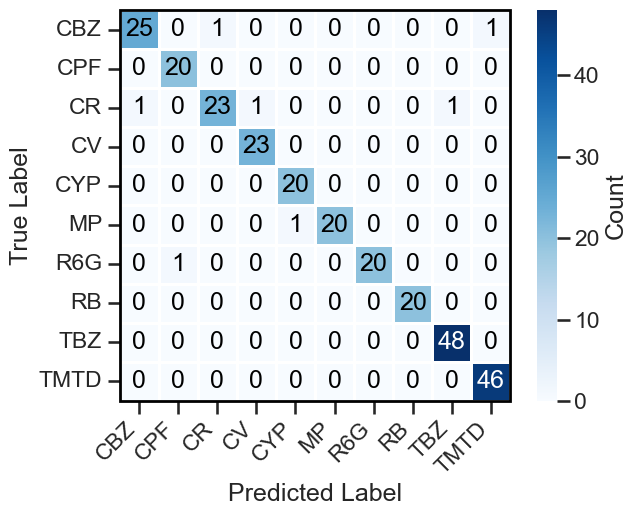

✅ Saved Confusion Matrix -> ./output/confusion_matrix_xgb_val.pdf


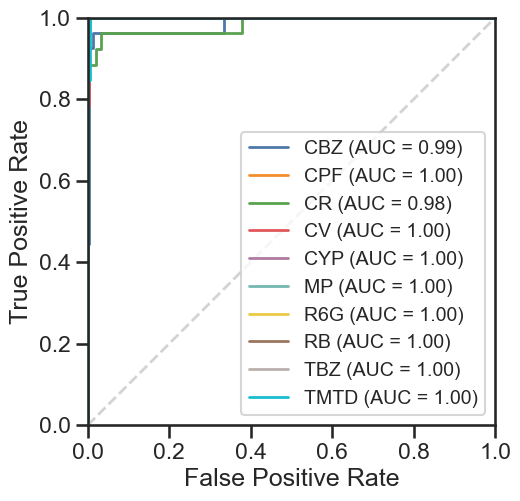

✅ Saved ROC Curves -> ./output/roc_curve_xgb_val.pdf


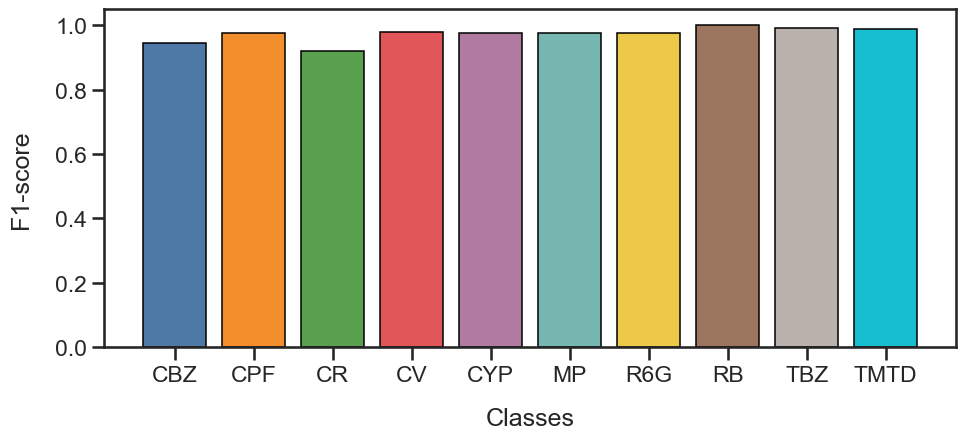

✅ Saved F1 Bar Plot -> ./output/f1_scores_xgb_val.pdf


In [23]:
from utils.utils_plot import plot_confusion_matrix, plot_roc_curves, plot_f1_scores

# ======= PLOTTING CONFUSION MATRIX =======
plot_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    class_names=class_names,
    out_dir="./output/",
    model_name="xgb_val"
)
# ======= PLOTTING ROC CURVES =======
plot_roc_curves(
    fpr, tpr, roc_auc, class_names,
    out_dir="./output",
    model_name="xgb_val"
)
# ======= PLOTTING F1-SCORES =======
plot_f1_scores(
    y_true=y_test,
    y_pred=y_pred,
    class_names=class_names,
    out_dir="./output",
    model_name="xgb_val"
)

#### Training and evaluating the SVM model (RBF kernel) using features extracted from CNN, including Classification Report, Confusion Matrix and ROC Curve

In [24]:
# -*- coding: utf-8 -*-
import os, json, warnings, datetime, pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc, f1_score)
from sklearn.preprocessing import StandardScaler, normalize, label_binarize
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings("ignore", category=UserWarning)

# ====== Paths ======
out_dir   = r"./output"
train_dir = r"./data/train_clean"
val_dir   = r"./data/val_clean"

# ====== LOAD FEATURES & LABELS ======
X = np.load(os.path.join(out_dir, "features_cnn.npy"))
y = np.load(os.path.join(out_dir, "labels_cnn.npy"))

# Class names
cls_path = os.path.join(out_dir, "classes.json")
if os.path.exists(cls_path):
    with open(cls_path, "r", encoding="utf-8") as f:
        class_names = json.load(f)
else:
    class_names = ['CBZ', 'CPF', 'CR', 'CV', 'CYP', 'MP', 'R6G', 'RB', 'TBZ', 'TMTD']
n_classes = len(class_names)

# ====== TRAIN/VAL FOLLOW ORDER OF CONCAT ======
fn_path = os.path.join(out_dir, "filenames_cnn.json")

def count_images(root):
    exts = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}
    cnt = 0
    for d,_,files in os.walk(root):
        cnt += sum(1 for f in files if os.path.splitext(f.lower())[1] in exts)
    return cnt

if os.path.exists(fn_path):
    with open(fn_path, "r", encoding="utf-8") as f:
        filenames = json.load(f)
    is_train = np.array([("/train_clean/" in p) or ("\\train_clean\\" in p) for p in filenames], dtype=bool)
    is_val   = np.array([("/val_clean/"   in p) or ("\\val_clean\\"   in p) for p in filenames], dtype=bool)
else:
    n_train = count_images(train_dir)
    is_train = np.zeros(len(y), dtype=bool); is_train[:n_train] = True
    is_val   = ~is_train

X_train, y_train = X[is_train], y[is_train]
X_test,  y_test  = X[is_val],   y[is_val]
print(f"Shapes -> X_train: {X_train.shape} y_train: {y_train.shape} | X_test: {X_test.shape} y_test: {y_test.shape}")

# ====== PRE-PROCESSING MODES ======
def prep_fit(mode, Xtr):
    if mode == "std":
        sc = StandardScaler().fit(Xtr)
        return {"scaler": sc, "pca": None}
    if mode == "l2":
        return {"scaler": "L2", "pca": None}
    if mode == "std+pca":
        sc = StandardScaler().fit(Xtr)
        Xtr_s = sc.transform(Xtr)
        pca = PCA(n_components=128, whiten=True, random_state=42).fit(Xtr_s)
        return {"scaler": sc, "pca": pca}
    raise ValueError("unknown mode")

def prep_transform(meta, X_):
    sc, pca = meta["scaler"], meta["pca"]
    if sc == "L2":
        return normalize(X_, axis=1)
    X_ = sc.transform(X_)
    if pca is not None:
        X_ = pca.transform(X_)
    return X_

def fold_preprocess(mode, Xtr_f, Xva_f):
    meta = prep_fit(mode, Xtr_f)
    return prep_transform(meta, Xtr_f), prep_transform(meta, Xva_f), meta

# ====== GRID TUNE WITH CV (no leakage) ======
modes = ["std+pca"]
C_list = [1, 2, 4, 8]
gamma_list = ["scale", "auto", 0.02, 0.05]
cw_list = [None, "balanced"]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best = {"score": -1}
for mode in modes:
    for cw in cw_list:
        for C in C_list:
            for gamma in gamma_list:
                f1s = []
                for tr_idx, va_idx in cv.split(X_train, y_train):
                    Xtr_f, Xva_f = X_train[tr_idx], X_train[va_idx]
                    ytr_f, yva_f = y_train[tr_idx], y_train[va_idx]

                    Xtr2, Xva2, _ = fold_preprocess(mode, Xtr_f, Xva_f)

                    clf = SVC(kernel='rbf', probability=True,
                              class_weight=cw, C=C, gamma=gamma, random_state=42)
                    clf.fit(Xtr2, ytr_f)
                    yva_pred = clf.predict(Xva2)
                    f1s.append(f1_score(yva_f, yva_pred, average="macro"))
                score = float(np.mean(f1s))
                if score > best["score"]:
                    best.update({"score": score, "mode": mode, "cw": cw, "C": C, "gamma": gamma})

print(f"Best CV macro-F1: {best['score']:.4f} | mode={best['mode']} | cw={best['cw']} | C={best['C']} | gamma={best['gamma']}")

# ====== TRAIN BEST OVER TRAIN & TEST ON VAL ======
meta_all = prep_fit(best["mode"], X_train)
Xtr2 = prep_transform(meta_all, X_train)
Xte2 = prep_transform(meta_all, X_test)

svm_model = SVC(kernel='rbf', probability=True,
                class_weight=best['cw'], C=best['C'], gamma=best['gamma'], random_state=42)
svm_model.fit(Xtr2, y_train)

y_pred = svm_model.predict(Xte2)
y_score = svm_model.predict_proba(Xte2)
acc = (y_pred == y_test).mean()
print(f"\n✅ Accuracy SVM tuned (val_clean): {acc*100:.2f} %")

print("\n📋 Classification Report (SVM tuned):")
print(classification_report(y_test, y_pred, target_names=class_names, digits=3))

# ====== Save model ======
stamp = datetime.datetime.now().strftime("%Y%m%d")
save_pkl = os.path.join(out_dir, f"svm_on_cnn_tuned_{best['mode']}_{stamp}.pkl")
payload = {
    "svm": svm_model,
    "classes": class_names,
    "mode": best["mode"],
    "class_weight": best["cw"],
    "C": best["C"],
    "gamma": best["gamma"],
    "scaler": meta_all["scaler"],
    "pca": meta_all["pca"],
}
with open(save_pkl, "wb") as f:
    pickle.dump(payload, f)
print("💾 Saved:", save_pkl)


Shapes -> X_train: (1075, 512) y_train: (1075,) | X_test: (272, 512) y_test: (272,)
Best CV macro-F1: 1.0000 | mode=std+pca | cw=None | C=1 | gamma=scale

✅ Accuracy SVM tuned (val_clean): 77.57 %

📋 Classification Report (SVM tuned):
              precision    recall  f1-score   support

         CBZ      0.762     0.593     0.667        27
         CPF      0.909     0.500     0.645        20
          CR      0.875     0.538     0.667        26
          CV      0.885     1.000     0.939        23
         CYP      0.875     0.700     0.778        20
          MP      0.679     0.905     0.776        21
         R6G      0.882     0.714     0.789        21
          RB      0.786     0.550     0.647        20
         TBZ      0.783     0.979     0.870        48
        TMTD      0.667     0.913     0.771        46

    accuracy                          0.776       272
   macro avg      0.810     0.739     0.755       272
weighted avg      0.795     0.776     0.766       272

💾 Save

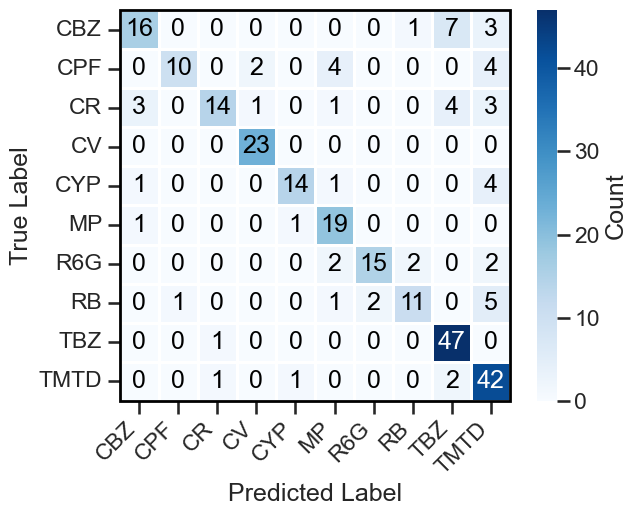

✅ Saved Confusion Matrix -> ./output/confusion_matrix_svm_val.pdf


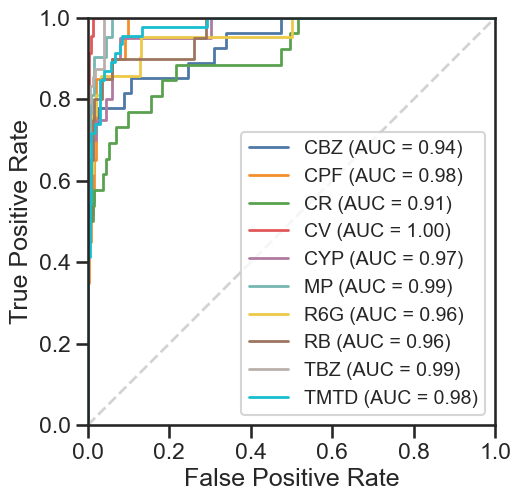

✅ Saved ROC Curves -> ./output/roc_curve_svm_val.pdf


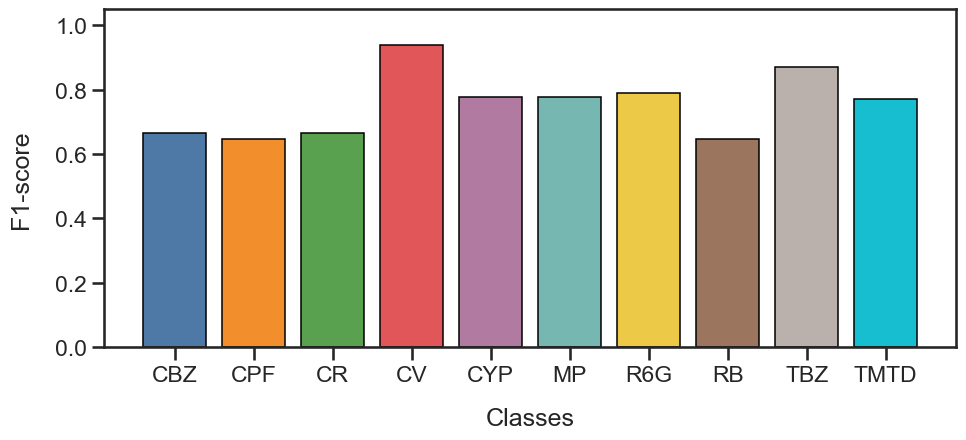

✅ Saved F1 Bar Plot -> ./output/f1_scores_svm_val.pdf


In [25]:
from utils.utils_plot import plot_confusion_matrix, plot_roc_curves, plot_f1_scores

# ======= PLOTTING CONFUSION MATRIX =======
plot_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    class_names=class_names,
    out_dir="./output/",
    model_name="svm_val"
)
# ======= PLOTTING ROC CURVES =======
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plot_roc_curves(
    fpr, tpr, roc_auc, class_names,
    out_dir="./output/",
    model_name="svm_val"
)
# ======= PLOTTING F1-SCORES =======
plot_f1_scores(
    y_true=y_test,
    y_pred=y_pred,
    class_names=class_names,
    out_dir="./output",
    model_name="svm_val"
)

#### Training and evaluating the VotingClassifier model (SVC+XGBoost) using features extracted from CNN, including Classification Report, Confusion Matrix and ROC Curve

In [37]:
import os, json, joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import learning_curve
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler

# ====== Paths ======
out_dir   = r"./output"
train_dir = r"./data/train_clean"
val_dir   = r"./data/val_clean"

# ====== 1) Load features & Class names (from ResNet18) ======
X = np.load(os.path.join(out_dir, "features_cnn.npy"))
y = np.load(os.path.join(out_dir, "labels_cnn.npy"))

# Class names according to ImageFolder (ensure correct order 0..9)
cls_path = os.path.join(out_dir, "classes.json")
if os.path.exists(cls_path):
    class_names = json.load(open(cls_path, "r", encoding="utf-8"))
else:
    class_names = ['CBZ', 'CPF', 'CR', 'CV', 'CYP', 'MP', 'R6G', 'RB', 'TBZ', 'TMTD']
num_classes = len(class_names)

# ====== 2) Divide train/test follows train_clean & val_clean ======
fn_path = os.path.join(out_dir, "filenames_cnn.json")
def split_by_names(fns):
    is_tr = np.array([("/train_clean/" in p) or ("\\train_clean\\" in p) for p in fns], bool)
    is_va = np.array([("/val_clean/"   in p) or ("\\val_clean\\"   in p) for p in fns], bool)
    return is_tr, is_va

if os.path.exists(fn_path):
    filenames = json.load(open(fn_path, "r", encoding="utf-8"))
    is_train, is_val = split_by_names(filenames)
else:
    exts = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}
    def count_imgs(root):
        c = 0
        for d, _, fs in os.walk(root):
            c += sum(1 for f in fs if os.path.splitext(f.lower())[1] in exts)
        return c
    n_train = count_imgs(train_dir)
    is_train = np.zeros(len(y), dtype=bool); is_train[:n_train] = True
    is_val = ~is_train

X_train, y_train = X[is_train], y[is_train]
X_test,  y_test  = X[is_val],   y[is_val]
print(f"Shapes -> X_train: {X_train.shape} y_train: {y_train.shape} | X_test: {X_test.shape} y_test: {y_test.shape}")

# ====== 3) MODEL DEFINITION ======
# Define base models 
svc = SVC(kernel='rbf', probability=True,
          class_weight='balanced', C=1, gamma='scale', random_state=42)

xgb = XGBClassifier(
    n_estimators=400, max_depth=6, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.85,
    objective="multi:softprob", num_class=num_classes,
    eval_metric="mlogloss", tree_method="hist",
    random_state=42, n_jobs=-1
)

# Voting classifier
voting = VotingClassifier(
    estimators=[('svc', svc), ('xgb', xgb)],
    voting='soft'
)

# Add PCA + Scaling before voting ===
voting_model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=128, whiten=True, random_state=42)),
    ('voting', voting)
])

voting_model.fit(X_train, y_train)

# ====== 4) REPORT ======
y_pred = voting_model.predict(X_test)
y_score = voting_model.predict_proba(X_test)
acc = (y_pred == y_test).mean() * 100
print(f"\n✅ Accuracy VotingClassifier (val_clean): {acc:.2f}%")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=3))

# ====== 5) SAVE MODEL ======
joblib.dump(voting_model, os.path.join(out_dir, "voting_svm_xgb.pkl"))
print(f"✅ Save VotingClassifier into '{os.path.join(out_dir, 'voting_svm_xgb.pkl')}'")

Shapes -> X_train: (1075, 512) y_train: (1075,) | X_test: (272, 512) y_test: (272,)

✅ Accuracy VotingClassifier (val_clean): 76.10%

📊 Classification Report:
              precision    recall  f1-score   support

         CBZ      0.842     0.593     0.696        27
         CPF      0.706     0.600     0.649        20
          CR      0.812     0.500     0.619        26
          CV      0.952     0.870     0.909        23
         CYP      0.778     0.700     0.737        20
          MP      0.731     0.905     0.809        21
         R6G      0.875     0.667     0.757        21
          RB      0.714     0.500     0.588        20
         TBZ      0.738     1.000     0.850        48
        TMTD      0.683     0.891     0.774        46

    accuracy                          0.761       272
   macro avg      0.783     0.722     0.739       272
weighted avg      0.773     0.761     0.752       272

✅ Save VotingClassifier into './output/voting_svm_xgb.pkl'


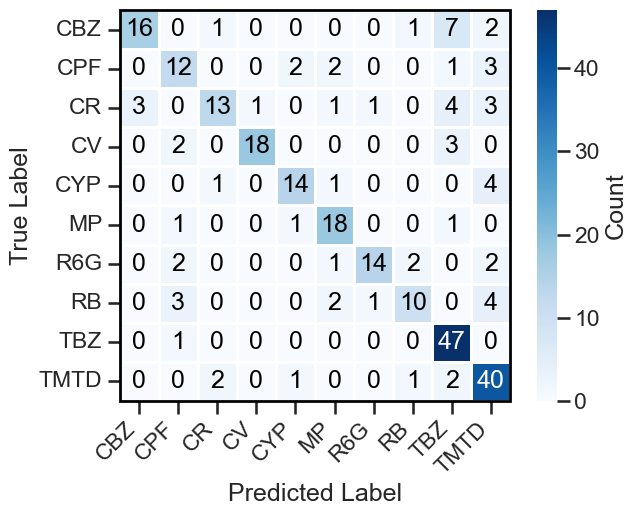

✅ Saved Confusion Matrix -> ./output/confusion_matrix_voting_val.pdf


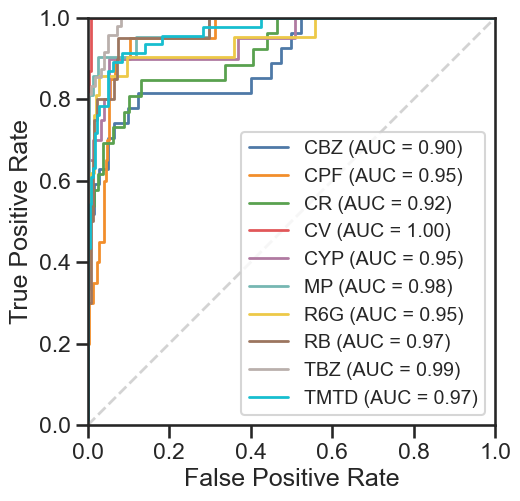

✅ Saved ROC Curves -> ./output/roc_curve_voting_val.pdf


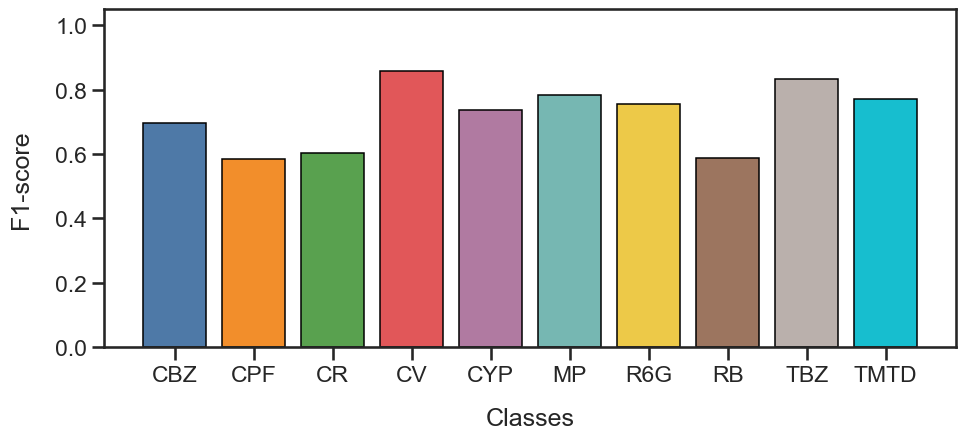

✅ Saved F1 Bar Plot -> ./output/f1_scores_voting_val.pdf


In [27]:
from utils.utils_plot import plot_confusion_matrix, plot_roc_curves, plot_f1_scores

# ======= PLOTTING CONFUSION MATRIX =======
plot_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    class_names=class_names,
    out_dir="./output/",
    model_name="voting_val"
)
# ======= PLOTTING ROC CURVES =======
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plot_roc_curves(
    fpr, tpr, roc_auc, class_names,
    out_dir="./output/",
    model_name="voting_val"
)
# ======= PLOTTING F1-SCORES =======
plot_f1_scores(
    y_true=y_test,
    y_pred=y_pred,
    class_names=class_names,
    out_dir="./output/",
    model_name="voting_val"
)

#### Optimized parameters with GridSearchCV

In [28]:
# ===== SVM + GridSearchCV =====
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib

# --- 1) Load features ---
DATA_ROOT = Path(r"./output")
X = np.load(DATA_ROOT / "features_cnn.npy")
y = np.load(DATA_ROOT / "labels_cnn.npy").ravel() # ensure 1D array

print("X:", X.shape, "| y:", y.shape)

# --- 2) Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- 3) Pipeline: StandardScaler -> SVC ---
pipe = Pipeline([
    ("scaler", StandardScaler()), 
    ('pca', PCA(n_components=128, whiten=True, random_state=42)),
    ("svc", SVC())
])

# --- 4) Grid parameters ---
param_grid = {
    "svc__kernel": ["rbf", "linear", "poly"],
    "svc__C": [1, 2, 4, 8],
    "svc__gamma": ["scale", "auto"],   # only for 'rbf', 'poly', 'sigmoid'
    "svc__degree": [2, 3],             # only for 'poly'
    "svc__class_weight": [None, "balanced"],  # if imbalanced try 'balanced'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("\n✅ Best Params:", grid.best_params_)
print("✅ Best CV Accuracy: {:.4f}".format(grid.best_score_))

# --- 5) Evaluate on test ---
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("\n✅ Test Accuracy: {:.4f}".format(acc))
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

# --- 6) Save model ---
out_path = DATA_ROOT / "best_svm_gridsearch.joblib"
joblib.dump(best_model, out_path)
print(f"\n💾 Saved best model -> {out_path}")

X: (1347, 512) | y: (1347,)
Fitting 5 folds for each of 96 candidates, totalling 480 fits

✅ Best Params: {'svc__C': 1, 'svc__class_weight': None, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
✅ Best CV Accuracy: 0.9499

✅ Test Accuracy: 0.9630

📋 Classification Report:
              precision    recall  f1-score   support

           0      0.885     0.852     0.868        27
           1      1.000     1.000     1.000        20
           2      1.000     0.846     0.917        26
           3      0.957     1.000     0.978        22
           4      0.952     1.000     0.976        20
           5      1.000     0.905     0.950        21
           6      1.000     1.000     1.000        20
           7      1.000     1.000     1.000        20
           8      0.941     1.000     0.970        48
           9      0.958     1.000     0.979        46

    accuracy                          0.963       270
   macro avg      0.969     0.960     0.964       270
weighted

#### Compare PCA, t-SNE, and UMAP

In [29]:
# -*- coding: utf-8 -*-
import os, json, warnings, datetime, pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc, f1_score)
from sklearn.preprocessing import StandardScaler, normalize, label_binarize
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from openTSNE import TSNE
from umap import UMAP

warnings.filterwarnings("ignore", category=UserWarning)

# ====== PATHS ======
out_dir   = r"./output"
train_dir = r"./data/train_clean"
val_dir   = r"./data/val_clean"

# ====== LOAD FEATURES & LABELS ======
X = np.load(os.path.join(out_dir, "features_cnn.npy"))
y = np.load(os.path.join(out_dir, "labels_cnn.npy"))

# ====== Class Names ======
cls_path = os.path.join(out_dir, "classes.json")
if os.path.exists(cls_path):
    with open(cls_path, "r", encoding="utf-8") as f:
        class_names = json.load(f)
else:
    class_names = ['CBZ', 'CPF', 'CR', 'CV', 'CYP', 'MP', 'R6G', 'RB', 'TBZ', 'TMTD']
n_classes = len(class_names)

# ====== Extract TRAIN / VAL ======
fn_path = os.path.join(out_dir, "filenames_cnn.json")

def count_images(root):
    exts = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}
    cnt = 0
    for d,_,files in os.walk(root):
        cnt += sum(1 for f in files if os.path.splitext(f.lower())[1] in exts)
    return cnt

if os.path.exists(fn_path):
    with open(fn_path, "r", encoding="utf-8") as f:
        filenames = json.load(f)
    is_train = np.array([("/train_clean/" in p) or ("\\train_clean\\" in p) for p in filenames], dtype=bool)
    is_val   = np.array([("/val_clean/"   in p) or ("\\val_clean\\"   in p) for p in filenames], dtype=bool)
else:
    n_train = count_images(train_dir)
    is_train = np.zeros(len(y), dtype=bool); is_train[:n_train] = True
    is_val   = ~is_train

X_train, y_train = X[is_train], y[is_train]
X_test,  y_test  = X[is_val],   y[is_val]
print(f"Shapes -> X_train: {X_train.shape} y_train: {y_train.shape} | X_test: {X_test.shape} y_test: {y_test.shape}")

Shapes -> X_train: (1075, 512) y_train: (1075,) | X_test: (272, 512) y_test: (272,)



🔍 Generating 2D PCA visualization...


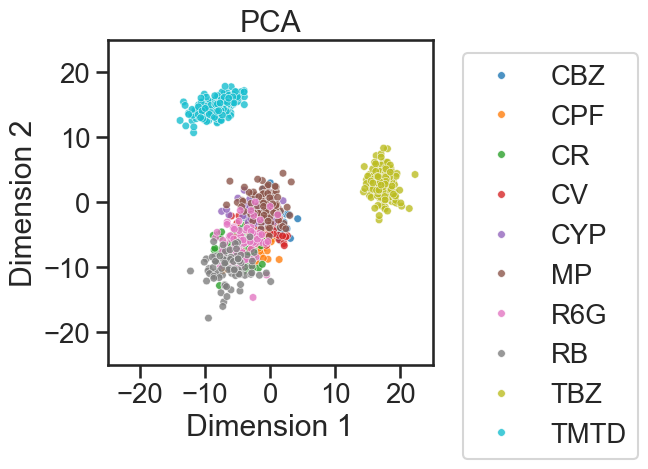

In [30]:
print("\n🔍 Generating 2D PCA visualization...")

# Standardize the data
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
#X_val_std = scaler.transform(X_val)

# Reduce dimensionality with PCA
pca = PCA(n_components=128, random_state=42)
X_train_pca = pca.fit_transform(X_train_std)
#X_val_pca = pca.transform(X_val_std)


sns.set_theme(style="ticks", palette="muted", context="talk", font="Arial", font_scale=1.2)

# Plot PCA
plt.figure(figsize=(7, 7))
ax = plt.gca()
sns.scatterplot(
    x=X_train_pca[:,0], y=X_train_pca[:,1],
    hue=[class_names[i] for i in y_train],
    palette="tab10", s=30, alpha=0.8
)
ax.set_xlim(-25, 25)
ax.set_ylim(-25, 25)
ax.set_xticks(np.arange(-20, 30, 10))
ax.set_yticks(np.arange(-20, 30, 10))
ax.set_aspect('equal')
ax.set_title("PCA")
ax.set_xlabel(f"Dimension 1")
ax.set_ylabel(f"Dimension 2")
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "pca_cnn_features_train.pdf"), bbox_inches="tight")
plt.show()


🔍 Fitting StandardScaler & openTSNE (2D)...


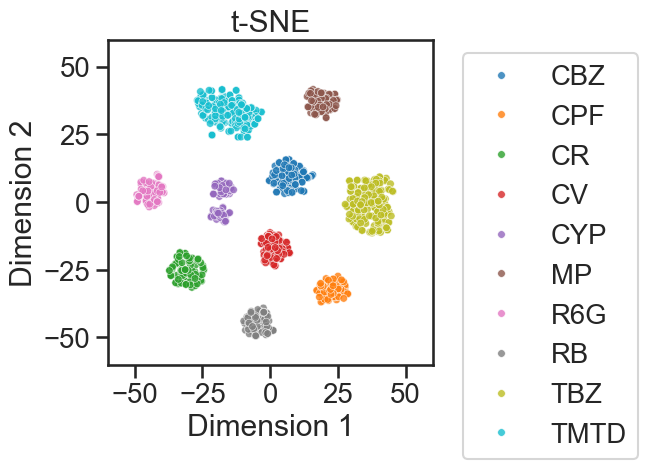

In [31]:
print("\n🔍 Fitting StandardScaler & openTSNE (2D)...")

tsne = TSNE(
    n_components=2,
    perplexity=20,
    n_iter=300,
    random_state=42,
    n_jobs=-1
)

X_train_tsne = np.array(tsne.fit(X_train_std))

# ====== Visualization t-SNE space ======
sns.set_theme(style="ticks", palette="muted", context="talk", font="Arial", font_scale=1.2)

plt.figure(figsize=(7, 7))
ax = plt.gca()

sns.scatterplot(
    x=X_train_tsne[:,0], y=X_train_tsne[:,1],
    hue=[class_names[i] for i in y_train],
    palette="tab10", s=30, alpha=0.8)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_xticks(np.arange(-50, 55, 25))
ax.set_yticks(np.arange(-50, 55, 25))
ax.set_aspect('equal')
ax.set_title("t-SNE")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout() 
plt.savefig(os.path.join(out_dir, "tsne_cnn_features_train.pdf"), bbox_inches="tight")
plt.show()


🔍 Generating 2D UMAP visualization...


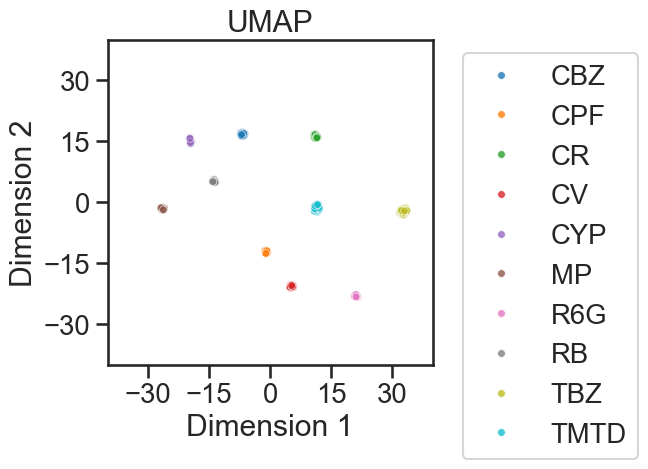

In [32]:
# ====== UMAP VISUALIZATION (2D) ======
print("\n🔍 Generating 2D UMAP visualization...")

umap = UMAP(
    n_components=2,
    n_neighbors=20,
    min_dist=0.1,
    metric='euclidean',
    random_state=42
)

X_train_umap = np.array(umap.fit_transform(X_train_std))

sns.set_theme(style="ticks", palette="muted", context="talk", font="Arial", font_scale=1.2)

# Plot UMAP
plt.figure(figsize=(7, 7))
ax = plt.gca()

sns.scatterplot(
    x=X_train_umap[:,0], y=X_train_umap[:,1],
    hue=[class_names[i] for i in y_train],
    palette="tab10", s=30, alpha=0.8)
ax.set_xlim(-40, 40)
ax.set_ylim(-40, 40)
ax.set_xticks(np.arange(-30, 35, 15))
ax.set_yticks(np.arange(-30, 35, 15))
ax.set_aspect('equal')
ax.set_title("UMAP")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "umap_cnn_features_train.pdf"), bbox_inches="tight")
plt.show()

#### Training SVM with t-SNE

In [33]:
from openTSNE import TSNE

# ====== PREPROCESS (StandardScaler + openTSNE) ======
def prep_fit_tsne(X_train):
    sc = StandardScaler().fit(X_train)
    X_scaled = sc.transform(X_train)

    # Initialize and fit openTSNE
    tsne = TSNE(
        n_components=2,
        perplexity=10,
        n_iter=300,
        n_jobs=-1,
        random_state=42
    )
    embedding = tsne.fit(X_scaled)

    return {"scaler": sc, "tsne": tsne, "embedding": embedding}

def prep_transform_tsne(meta, X):
    sc, tsne, embedding = meta["scaler"], meta["tsne"], meta["embedding"]
    X_scaled = sc.transform(X)

    # Use the existing embedding to transform new points
    return embedding.transform(X_scaled)

# ====== TRAIN + TEST PIPELINE ======
print("🚀 Running SVM with t-SNE features...")

meta_all = prep_fit_tsne(X_train)
Xtr2 = meta_all["embedding"]        # t-SNE embedding of training set
Xte2 = prep_transform_tsne(meta_all, X_test)  # map test set into same space

svm_model = SVC(
    kernel="rbf", probability=True,
    class_weight="balanced", C=1, gamma="scale", random_state=42
)
svm_model.fit(Xtr2, y_train)

# ====== EVALUATION ======
y_pred = svm_model.predict(Xte2)
acc = (y_pred == y_test).mean()
print(f"\n✅ Accuracy (SVM+tSNE): {acc*100:.2f} %")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=3))

# ====== SAVE MODEL ======
stamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_pkl = os.path.join(out_dir, f"svm_on_cnn_tsne_{stamp}.pkl")
payload = {
    "svm": svm_model,
    "classes": class_names,
    "scaler": meta_all["scaler"],
    "tsne": meta_all["tsne"],
    "embedding": meta_all["embedding"]
}
with open(save_pkl, "wb") as f:
    pickle.dump(payload, f)
print("💾 Saved:", save_pkl)

🚀 Running SVM with t-SNE features...

✅ Accuracy (SVM+tSNE): 79.78 %

📋 Classification Report:
              precision    recall  f1-score   support

         CBZ      0.833     0.741     0.784        27
         CPF      0.688     0.550     0.611        20
          CR      0.824     0.538     0.651        26
          CV      0.852     1.000     0.920        23
         CYP      0.750     0.750     0.750        20
          MP      0.714     0.952     0.816        21
         R6G      0.875     0.667     0.757        21
          RB      0.923     0.600     0.727        20
         TBZ      0.842     1.000     0.914        48
        TMTD      0.741     0.870     0.800        46

    accuracy                          0.798       272
   macro avg      0.804     0.767     0.773       272
weighted avg      0.804     0.798     0.790       272

💾 Saved: ./output/svm_on_cnn_tsne_20251115_035758.pkl


#### Training SVM with UMAP

In [34]:
# ====== PREPROCESS (StandardScaler + UMAP) ======
def prep_fit_umap(X_train):
    sc = StandardScaler().fit(X_train)
    X_scaled = sc.transform(X_train)

    reducer = UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        metric="euclidean",
        random_state=42,
        n_jobs=-1
    ).fit(X_scaled)

    return {"scaler": sc, "umap": reducer}

def prep_transform_umap(meta, X):
    sc, reducer = meta["scaler"], meta["umap"]
    X_scaled = sc.transform(X)
    return reducer.transform(X_scaled)

# ====== TRAIN + TEST PIPELINE ======
print("🚀 Running SVM with UMAP features...")

meta_all = prep_fit_umap(X_train)
Xtr2 = prep_transform_umap(meta_all, X_train)
Xte2 = prep_transform_umap(meta_all, X_test)

svm_model = SVC(
    kernel="rbf", probability=True,
    class_weight="balanced", C=1, gamma="scale", random_state=42
)
svm_model.fit(Xtr2, y_train)

# ====== EVALUATION ======
y_pred = svm_model.predict(Xte2)
acc = (y_pred == y_test).mean()
print(f"\n✅ Accuracy (SVM+UMAP): {acc*100:.2f} %")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=3))

# ====== SAVE MODEL ======
stamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_pkl = os.path.join(out_dir, f"svm_on_cnn_umap_{stamp}.pkl")
payload = {
    "svm": svm_model,
    "classes": class_names,
    "scaler": meta_all["scaler"],
    "umap": meta_all["umap"]
}
with open(save_pkl, "wb") as f:
    pickle.dump(payload, f)

print("💾 Saved:", save_pkl)

🚀 Running SVM with UMAP features...

✅ Accuracy (SVM+UMAP): 79.78 %

📋 Classification Report:
              precision    recall  f1-score   support

         CBZ      0.656     0.778     0.712        27
         CPF      0.778     0.700     0.737        20
          CR      0.667     0.538     0.596        26
          CV      0.958     1.000     0.979        23
         CYP      0.833     0.750     0.789        20
          MP      0.655     0.905     0.760        21
         R6G      0.923     0.571     0.706        21
          RB      1.000     0.700     0.824        20
         TBZ      0.857     1.000     0.923        48
        TMTD      0.787     0.804     0.796        46

    accuracy                          0.798       272
   macro avg      0.811     0.775     0.782       272
weighted avg      0.808     0.798     0.794       272

💾 Saved: ./output/svm_on_cnn_umap_20251115_035801.pkl
